In [2]:
# PART 1: Setup and Dataset Download
# Run this cell first to set up the environment and download data

# Install required packages
!pip install kaggle opencv-python -q

# Create directory for Kaggle API token
!mkdir -p ~/.kaggle

# IMPORTANT: You need to upload your kaggle.json file here
# To get kaggle.json:
# 1. Go to https://www.kaggle.com/settings
# 2. Click on "Create New API Token"
# 3. Download the kaggle.json file
from google.colab import files
files.upload()  # Upload your kaggle.json when prompted

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"schinnamudiam","key":"c1e8a23342495adfb901b4d678e82c5f"}'}

In [3]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download and extract the CelebA dataset
!kaggle datasets download -d jessicali9530/celeba-dataset
!mkdir -p celeba_data
!unzip celeba-dataset.zip -d celeba_data
!rm celeba-dataset.zip  # Remove zip to save space

Streaming output truncated to the last 5000 lines.
  inflating: celeba_data/img_align_celeba/img_align_celeba/197604.jpg  
  inflating: celeba_data/img_align_celeba/img_align_celeba/197605.jpg  
  inflating: celeba_data/img_align_celeba/img_align_celeba/197606.jpg  
  inflating: celeba_data/img_align_celeba/img_align_celeba/197607.jpg  
  inflating: celeba_data/img_align_celeba/img_align_celeba/197608.jpg  
  inflating: celeba_data/img_align_celeba/img_align_celeba/197609.jpg  
  inflating: celeba_data/img_align_celeba/img_align_celeba/197610.jpg  
  inflating: celeba_data/img_align_celeba/img_align_celeba/197611.jpg  
  inflating: celeba_data/img_align_celeba/img_align_celeba/197612.jpg  
  inflating: celeba_data/img_align_celeba/img_align_celeba/197613.jpg  
  inflating: celeba_data/img_align_celeba/img_align_celeba/197614.jpg  
  inflating: celeba_data/img_align_celeba/img_align_celeba/197615.jpg  
  inflating: celeba_data/img_align_celeba/img_align_celeba/197616.jpg  
  inflating: 

In [4]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image, ImageDraw
import cv2
from pathlib import Path
from typing import Tuple, List
import pandas as pd
from tqdm import tqdm

In [5]:
class ExpressionPatterns:
    """Handle expression-related pattern generation"""

    @staticmethod
    def get_pattern(bbox: Tuple[int, int, int, int], expression: str) -> List[Tuple[int, int]]:
        x1, y1, x2, y2 = bbox
        width = x2 - x1
        height = y2 - y1
        center_x = (x1 + x2) // 2
        center_y = (y1 + y2) // 2

        if expression == 'smile':
            return [(x1 + width * t/20,
                    center_y + height * 0.3 * np.sin(np.pi * t/20))
                    for t in range(21)]
        elif expression == 'frown':
            return [(x1 + width * t/20,
                    center_y - height * 0.3 * np.sin(np.pi * t/20))
                    for t in range(21)]
        elif expression == 'laugh':
            radius = min(width, height) // 3
            return [(center_x + radius * np.cos(2*np.pi * t/40),
                    center_y + radius * np.sin(2*np.pi * t/40))
                    for t in range(41)]
        else:  # neutral
            return [(x1, center_y), (x2, center_y)]

class MaskGenerator:
    """Handle mask generation"""

    def __init__(self, image_size: Tuple[int, int], sketch_thickness: int = 2):
        self.image_size = image_size
        self.sketch_thickness = sketch_thickness

    def create_binary_mask(self, bbox: Tuple[int, int, int, int]) -> np.ndarray:
        mask = np.zeros(self.image_size, dtype=np.uint8)
        cv2.rectangle(mask, (bbox[0], bbox[1]), (bbox[2], bbox[3]), 255, -1)
        return mask

    def create_sketch_mask(self, pattern_points: List[Tuple[int, int]]) -> np.ndarray:
        mask = Image.new('L', self.image_size, 0)
        draw = ImageDraw.Draw(mask)

        for i in range(len(pattern_points) - 1):
            draw.line([pattern_points[i], pattern_points[i+1]],
                     fill=255,
                     width=self.sketch_thickness)

        return np.array(mask)

In [6]:
def create_dataloader(
    root_dir: str,
    batch_size: int = 16,
    split: str = 'train',
    val_split: float = 0.1,
    num_workers: int = 2,
    image_size: tuple = (256, 256)
):
    """Create train and validation dataloaders"""

    # Create full dataset
    dataset = CelebADataset(
        root_dir=root_dir,
        image_size=image_size
    )

    # Calculate split sizes
    total_size = len(dataset)
    val_size = int(val_split * total_size)
    train_size = total_size - val_size

    # Split dataset
    train_dataset, val_dataset = torch.utils.data.random_split(
        dataset,
        [train_size, val_size]
    )

    # Select appropriate dataset based on split parameter
    if split == 'train':
        selected_dataset = train_dataset
    elif split == 'val':
        selected_dataset = val_dataset
    else:
        raise ValueError("Split must be either 'train' or 'val'")

    # Create dataloader
    dataloader = DataLoader(
        selected_dataset,
        batch_size=batch_size,
        shuffle=(split == 'train'),  # Only shuffle training data
        num_workers=num_workers,
        pin_memory=True
    )

    return dataloader

In [7]:
def visualize_batch(images, binary_masks, sketch_masks, num_samples: int = 4):
    """Visualize a batch of data"""
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    for i in range(num_samples):
        # Original image
        axes[i, 0].imshow(images[i].permute(1, 2, 0) * 0.5 + 0.5)
        axes[i, 0].set_title('Original Image')

        # Binary mask
        axes[i, 1].imshow(binary_masks[i], cmap='gray')
        axes[i, 1].set_title('Binary Mask')

        # Sketch mask
        axes[i, 2].imshow(sketch_masks[i], cmap='gray')
        axes[i, 2].set_title('Sketch Mask')

    plt.tight_layout()
    plt.show()

In [ ]:
# Run this cell first to check the downloaded files
!ls celeba_data

img_align_celeba      list_bbox_celeba.csv     list_landmarks_align_celeba.csv
list_attr_celeba.csv  list_eval_partition.csv


In [65]:
class CelebADataset(Dataset):
    def __init__(self,
                 root_dir: str,
                 split: str = 'train',
                 split_ratio: float = 0.8,
                 transform=None,
                 image_size: Tuple[int, int] = (256, 256),
                 sketch_thickness: int = 2):
        """
        Args:
            root_dir: Root directory of CelebA dataset
            split: One of ['train', 'val', 'test']
            split_ratio: Ratio of data to use for training
            transform: Optional transform to be applied on images after initial processing
            image_size: Size of the output images
            sketch_thickness: Thickness of sketch lines
        """
        self.root_dir = Path(root_dir)
        self.img_dir = self.root_dir / 'img_align_celeba' / 'img_align_celeba'
        self.image_size = image_size
        self.sketch_thickness = sketch_thickness
        self.split = split
        self.transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ]) if transform is None else transform

        # Load attributes and landmarks
        print("Loading attributes...")
        self.attr_df = pd.read_csv(self.root_dir / 'list_attr_celeba.csv')
        print(f"Loaded {len(self.attr_df)} attributes")

        print("Loading landmarks...")
        self.landmarks_df = pd.read_csv(self.root_dir / 'list_landmarks_align_celeba.csv')
        print(f"Loaded {len(self.landmarks_df)} landmarks")

        # Get list of all image files
        all_image_files = sorted(list(self.img_dir.glob('*.jpg')))
        total_images = len(all_image_files)
        print(f"Found {total_images} total images")

        # Split the dataset
        train_idx = int(total_images * split_ratio)
        val_idx = train_idx + int((total_images - train_idx) / 2)

        if split == 'train':
            self.image_files = all_image_files[:train_idx]
        elif split == 'val':
            self.image_files = all_image_files[train_idx:val_idx]
        elif split == 'test':
            self.image_files = all_image_files[val_idx:]
        else:
            raise ValueError(f"Split must be one of ['train', 'val', 'test'], got {split}")

        print(f"Using {len(self.image_files)} images for {split}")



    def __getitem__(self, idx: int):
        try:
            # Get image path
            img_path = self.image_files[idx]
            img_name = img_path.name

            # Load image as PIL Image
            image = Image.open(img_path).convert('RGB')

            # Get landmarks and create bbox
            landmarks = self.landmarks_df.iloc[idx]
            bbox = self._get_mouth_bbox(landmarks)

            # Get attributes and determine expression
            attributes = self.attr_df.iloc[idx]
            expression = self._determine_expression(attributes)

            # Generate pattern points
            pattern_points = ExpressionPatterns.get_pattern(bbox, expression)

            # Create masks (before tensor conversion)
            binary_mask = np.zeros(self.image_size, dtype=np.uint8)
            cv2.rectangle(binary_mask, (bbox[0], bbox[1]), (bbox[2], bbox[3]), 255, -1)
            sketch_mask = self._create_sketch_mask(pattern_points)

            # Convert image to tensor with normalization
            image_tensor = self.transform(image)

            # Convert masks to tensors (simple normalization)
            binary_mask = torch.from_numpy(binary_mask).float() / 255.0
            sketch_mask = torch.from_numpy(sketch_mask).float() / 255.0

            return image_tensor, binary_mask, sketch_mask

        except Exception as e:
            print(f"Error processing item {idx}: {str(e)}")
            print(f"Image path: {img_path}")
            raise
    def __len__(self) -> int:
        return len(self.image_files)

    # Rest of the methods remain the same
    def _get_mouth_bbox(self, landmarks: pd.Series) -> Tuple[int, int, int, int]:
        padding = 15
        mouth_left_x = landmarks['leftmouth_x']
        mouth_left_y = landmarks['leftmouth_y']
        mouth_right_x = landmarks['rightmouth_x']
        mouth_right_y = landmarks['rightmouth_y']

        x1 = max(0, min(mouth_left_x, mouth_right_x) - padding)
        x2 = min(self.image_size[0], max(mouth_left_x, mouth_right_x) + padding)

        center_y = (mouth_left_y + mouth_right_y) // 2
        y1 = max(0, center_y - padding)
        y2 = min(self.image_size[1], center_y + padding)

        return (int(x1), int(y1), int(x2), int(y2))

    def _determine_expression(self, attributes: pd.Series) -> str:
        smiling = attributes['Smiling']
        mouth_open = attributes['Mouth_Slightly_Open']

        if smiling == 1 and mouth_open == 1:
            return 'laugh'
        elif smiling == 1:
            return 'smile'
        elif mouth_open == 1:
            return 'neutral'
        else:
            return 'frown'

    def _create_sketch_mask(self, pattern_points: List[Tuple[int, int]]) -> np.ndarray:
        mask = Image.new('L', self.image_size, 0)
        draw = ImageDraw.Draw(mask)

        for i in range(len(pattern_points) - 1):
            draw.line([pattern_points[i], pattern_points[i+1]],
                     fill=255,
                     width=self.sketch_thickness)

        return np.array(mask)

In [9]:
def check_directory_structure(path):
    path = Path(path)
    print(f"\nChecking directory structure from: {path}")

    def print_directory_contents(directory, indent=""):
        print(f"{indent}Directory: {directory.name}/")
        for item in directory.iterdir():
            if item.is_file():
                print(f"{indent}  File: {item.name}")
            elif item.is_dir():
                print_directory_contents(item, indent + "  ")

    print_directory_contents(path)

# Add this before creating the dataset
print("Checking directory structure...")
check_directory_structure('celeba_data')

# Then create the dataset
print("\nCreating dataset...")
dataset = CelebADataset('celeba_data')

Streaming output truncated to the last 5000 lines.
      File: 064917.jpg
      File: 184826.jpg
      File: 164971.jpg
      File: 036817.jpg
      File: 085636.jpg
      File: 129507.jpg
      File: 081364.jpg
      File: 192678.jpg
      File: 188343.jpg
      File: 045279.jpg
      File: 039581.jpg
      File: 079892.jpg
      File: 141562.jpg
      File: 202505.jpg
      File: 111792.jpg
      File: 054012.jpg
      File: 019665.jpg
      File: 048717.jpg
      File: 063587.jpg
      File: 052411.jpg
      File: 063237.jpg
      File: 123007.jpg
      File: 143548.jpg
      File: 037702.jpg
      File: 162208.jpg
      File: 184690.jpg
      File: 185785.jpg
      File: 142263.jpg
      File: 072604.jpg
      File: 017563.jpg
      File: 083007.jpg
      File: 138495.jpg
      File: 095074.jpg
      File: 149934.jpg
      File: 185174.jpg
      File: 184694.jpg
      File: 182502.jpg
      File: 107096.jpg
      File: 027194.jpg
      File: 060680.jpg
      File: 197414.jpg
      

In [10]:
# First, let's check the actual contents of img_align_celeba
import os
img_dir = os.path.join('celeba_data', 'img_align_celeba')
print("Checking img_align_celeba contents:")
print(os.listdir(img_dir)[:5])  # Show first 5 files

Checking img_align_celeba contents:
['img_align_celeba']


In [11]:
# Check dataset size and sample distribution
def analyze_dataset(dataset):
    """Analyze dataset characteristics"""
    print(f"Total dataset size: {len(dataset)} images")

    # Check a few random samples
    print("\nChecking random samples...")
    random_indices = np.random.randint(0, len(dataset), 5)

    for idx in random_indices:
        try:
            image, binary_mask, sketch_mask = dataset[idx]
            print(f"\nSample {idx}:")
            print(f"Image shape: {image.shape}")
            print(f"Binary mask shape: {binary_mask.shape}")
            print(f"Sketch mask shape: {sketch_mask.shape}")
            print(f"Image value range: [{image.min():.2f}, {image.max():.2f}]")
            print(f"Binary mask value range: [{binary_mask.min():.2f}, {binary_mask.max():.2f}]")
            print(f"Sketch mask value range: [{sketch_mask.min():.2f}, {sketch_mask.max():.2f}]")
        except Exception as e:
            print(f"Error processing sample {idx}: {str(e)}")

    # Check expression distribution
    print("\nChecking expression distribution...")
    expressions = []
    for idx in tqdm(range(min(1000, len(dataset))), desc="Analyzing expressions"):
        try:
            attributes = dataset.attr_df.iloc[idx]
            expression = dataset._determine_expression(attributes)
            expressions.append(expression)
        except Exception as e:
            print(f"Error processing expression {idx}: {str(e)}")
            continue

    unique, counts = np.unique(expressions, return_counts=True)
    for expr, count in zip(unique, counts):
        percentage = (count / len(expressions)) * 100
        print(f"{expr}: {count} ({percentage:.2f}%)")
# To use it:
dataset = CelebADataset('celeba_data')
analyze_dataset(dataset)

# If you want to split the dataset into train/val/test:
from torch.utils.data import random_split

def create_data_splits(dataset, train_size=0.8, val_size=0.1, test_size=0.1):
    total_size = len(dataset)
    train_size = int(train_size * total_size)
    val_size = int(val_size * total_size)
    test_size = total_size - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(
        dataset,
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )

    print(f"Dataset splits:")
    print(f"Train size: {len(train_dataset)}")
    print(f"Validation size: {len(val_dataset)}")
    print(f"Test size: {len(test_dataset)}")

    return train_dataset, val_dataset, test_dataset

# Create the splits
train_dataset, val_dataset, test_dataset = create_data_splits(dataset)

# Create dataloaders for each split
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Check first batch from train loader
for images, binary_masks, sketch_masks in train_loader:
    print(f"\nFirst training batch:")
    print(f"Images shape: {images.shape}")
    print(f"Binary masks shape: {binary_masks.shape}")
    print(f"Sketch masks shape: {sketch_masks.shape}")
    break

Loading attributes...
Loaded 202599 attributes
Loading landmarks...
Loaded 202599 landmarks
Found 202599 total images
Using 162079 images for train
Total dataset size: 162079 images

Checking random samples...

Sample 69011:
Image shape: torch.Size([3, 256, 256])
Binary mask shape: torch.Size([256, 256])
Sketch mask shape: torch.Size([256, 256])
Image value range: [0.00, 1.00]
Binary mask value range: [0.00, 1.00]
Sketch mask value range: [0.00, 1.00]

Sample 111804:
Image shape: torch.Size([3, 256, 256])
Binary mask shape: torch.Size([256, 256])
Sketch mask shape: torch.Size([256, 256])
Image value range: [0.00, 1.00]
Binary mask value range: [0.00, 1.00]
Sketch mask value range: [0.00, 1.00]

Sample 139080:
Image shape: torch.Size([3, 256, 256])
Binary mask shape: torch.Size([256, 256])
Sketch mask shape: torch.Size([256, 256])
Image value range: [0.00, 0.98]
Binary mask value range: [0.00, 1.00]
Sketch mask value range: [0.00, 1.00]

Sample 99325:
Image shape: torch.Size([3, 256, 25

Analyzing expressions: 100%|██████████| 1000/1000 [00:00<00:00, 15188.39it/s]

frown: 377 (37.70%)
laugh: 390 (39.00%)
neutral: 113 (11.30%)
smile: 120 (12.00%)
Dataset splits:
Train size: 129663
Validation size: 16207
Test size: 16209



First training batch:
Images shape: torch.Size([32, 3, 256, 256])
Binary masks shape: torch.Size([32, 256, 256])
Sketch masks shape: torch.Size([32, 256, 256])


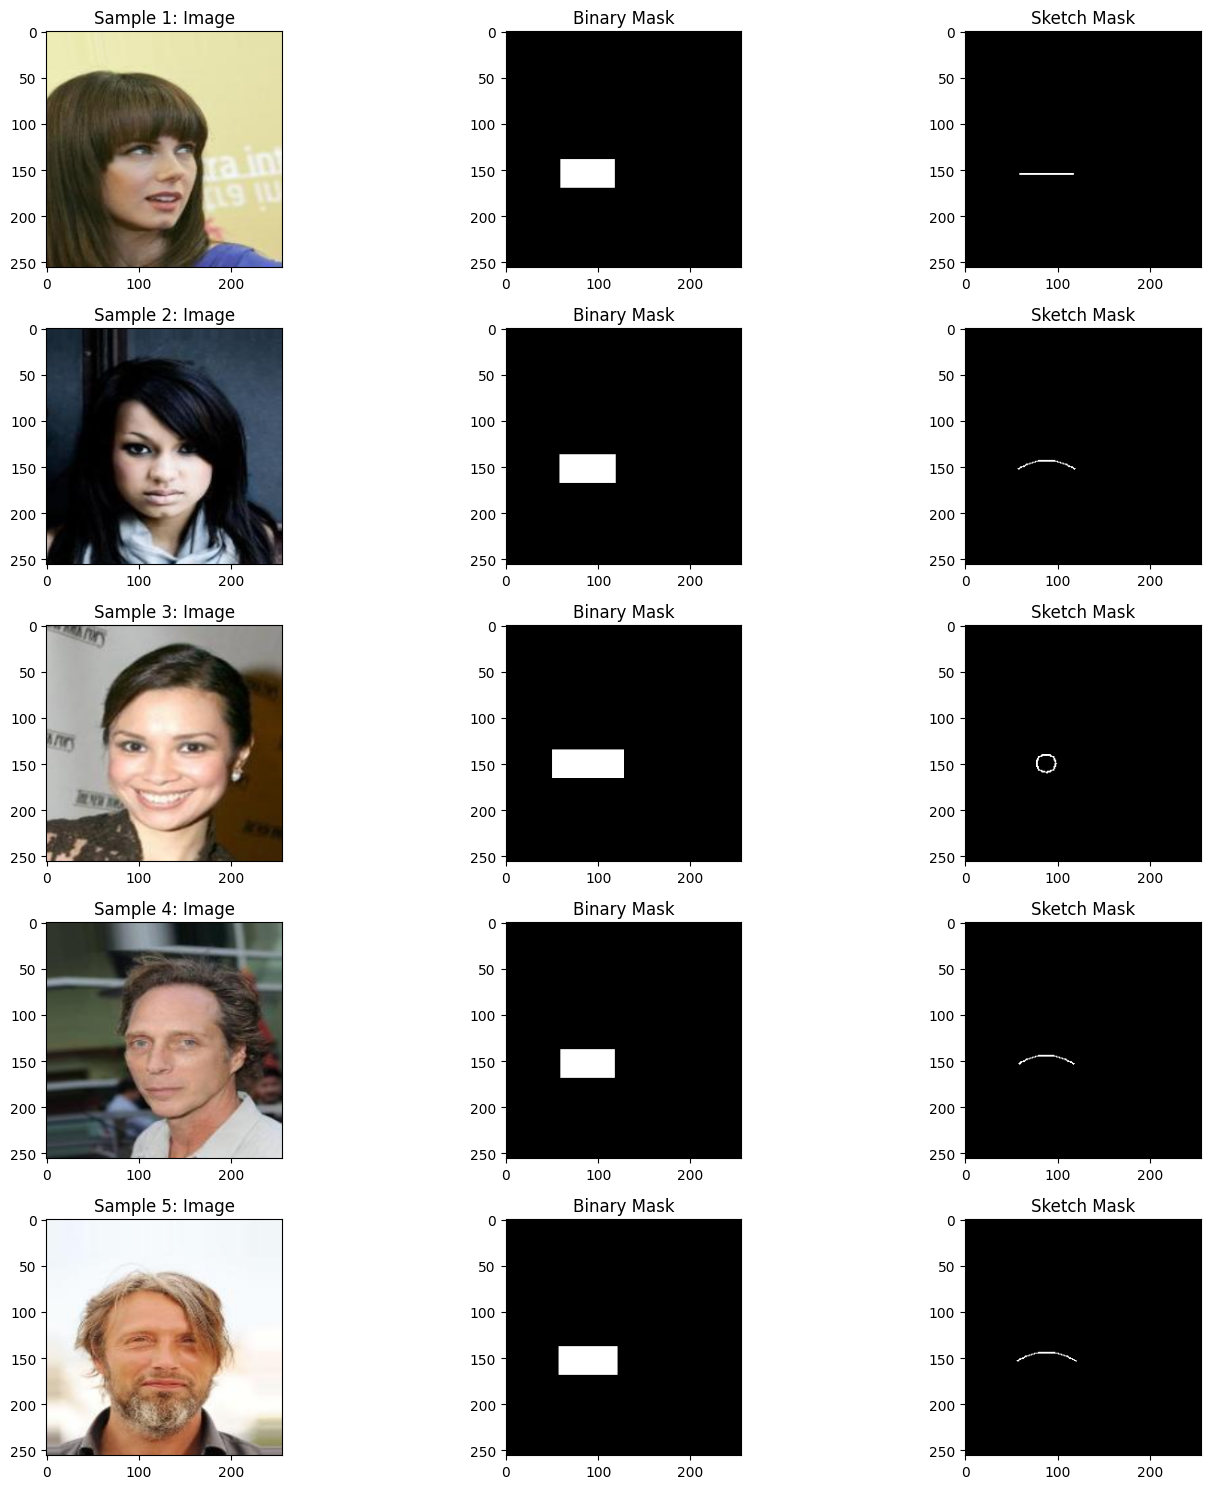

In [12]:
import matplotlib.pyplot as plt

def visualize_samples(dataset, num_samples=5):
    plt.figure(figsize=(15, 3*num_samples))

    for i in range(num_samples):
        idx = np.random.randint(0, len(dataset))
        image, binary_mask, sketch_mask = dataset[idx]

        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(image.permute(1, 2, 0))
        plt.title(f'Sample {i+1}: Image')

        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(binary_mask, cmap='gray')
        plt.title('Binary Mask')

        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(sketch_mask, cmap='gray')
        plt.title('Sketch Mask')

    plt.tight_layout()
    plt.show()

# Visualize some samples
visualize_samples(dataset)

In [ ]:
!pip install torch torchvision diffusers transformers -q


In [ ]:
# First, install all required packages
!pip install --upgrade diffusers transformers torch torchvision accelerate -q

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class SketchEncoder(nn.Module):
    """Encodes sketch patterns into feature representations"""
    def __init__(self, in_channels=1, hidden_dims=[64, 128, 256, 512]):
        super().__init__()
        modules = []

        # Convolutional encoder for sketch patterns
        for h_dim in hidden_dims:
            modules.extend([
                nn.Conv2d(in_channels, h_dim, 3, stride=2, padding=1),
                nn.BatchNorm2d(h_dim),
                nn.LeakyReLU()
            ])
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.final_projection = nn.Conv2d(hidden_dims[-1], hidden_dims[-1], 1)

    def forward(self, x):
        return self.final_projection(self.encoder(x))

class SpatialTransformer(nn.Module):
    """Applies self-attention over spatial features"""
    def __init__(self, dim, heads=8):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        encoder_layer = TransformerEncoderLayer(
            d_model=dim,
            nhead=heads,
            dim_feedforward=dim * 4,
            dropout=0.1,
            activation='relu'
        )
        self.transformer = TransformerEncoder(encoder_layer, num_layers=3)

    def forward(self, x):
        b, c, h, w = x.shape
        # Reshape for transformer
        x = x.flatten(2).permute(2, 0, 1)  # (H*W, B, C)
        x = self.norm(x)
        x = self.transformer(x)
        # Reshape back
        x = x.permute(1, 2, 0).view(b, c, h, w)
        return x

class SketchGuidedUNet(nn.Module):
    """U-Net architecture with sketch conditioning"""
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()

        # Sketch encoder
        self.sketch_encoder = SketchEncoder()

        # Encoder blocks
        self.enc1 = self._make_encoder_block(in_channels + 1, 64)    # +1 for mask
        self.enc2 = self._make_encoder_block(64, 128)
        self.enc3 = self._make_encoder_block(128, 256)
        self.enc4 = self._make_encoder_block(256, 512)

        # Spatial transformer for sketch features
        self.sketch_transformer = SpatialTransformer(512)

        # Feature fusion
        self.fusion = nn.Sequential(
            nn.Conv2d(1024, 512, 1),  # 512 from encoder + 512 from sketch
            nn.BatchNorm2d(512),
            nn.LeakyReLU()
        )

        # Decoder blocks with skip connections
        self.dec4 = self._make_decoder_block(512, 256)
        self.dec3 = self._make_decoder_block(512, 128)  # 256 + 256 from skip
        self.dec2 = self._make_decoder_block(256, 64)   # 128 + 128 from skip
        self.dec1 = self._make_decoder_block(128, 64)   # 64 + 64 from skip

        # Final output
        self.final = nn.Sequential(
            nn.Conv2d(64, out_channels, 3, padding=1),
            nn.Tanh()
        )

    def _make_encoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(),
            nn.MaxPool2d(2)
        )

    def _make_decoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, 2, stride=2),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU()
        )

    def forward(self, x, binary_mask, sketch_mask):
        # Concatenate input with binary mask
        x = torch.cat([x, binary_mask.unsqueeze(1)], dim=1)

        # Encoder pathway with skip connections
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)

        # Process sketch features
        sketch_features = self.sketch_encoder(sketch_mask.unsqueeze(1))
        sketch_features = self.sketch_transformer(sketch_features)

        # Fuse encoder and sketch features
        fused = self.fusion(torch.cat([e4, sketch_features], dim=1))

        # Decoder pathway with skip connections
        d4 = self.dec4(fused)
        d3 = self.dec3(torch.cat([d4, e3], dim=1))
        d2 = self.dec2(torch.cat([d3, e2], dim=1))
        d1 = self.dec1(torch.cat([d2, e1], dim=1))

        return self.final(d1)

class Discriminator(nn.Module):
    """PatchGAN discriminator for adversarial training"""
    def __init__(self, in_channels=3):
        super().__init__()

        def discriminator_block(in_filters, out_filters, normalize=True):
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels + 2, 64, normalize=False),  # +2 for masks
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.Conv2d(512, 1, 3, padding=1)
        )

    def forward(self, img, binary_mask, sketch_mask):
        x = torch.cat([img, binary_mask.unsqueeze(1), sketch_mask.unsqueeze(1)], dim=1)
        return self.model(x)


class ModelManager:
    """Handles saving and loading model states"""
    @staticmethod
    def save_model(generator, discriminator, g_optimizer, d_optimizer, epoch, best_val_loss, save_path):
        """Save the complete model state"""
        checkpoint = {
            'generator_state_dict': generator.state_dict(),
            'discriminator_state_dict': discriminator.state_dict(),
            'g_optimizer_state_dict': g_optimizer.state_dict(),
            'd_optimizer_state_dict': d_optimizer.state_dict(),
            'epoch': epoch,
            'best_val_loss': best_val_loss
        }

        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        torch.save(checkpoint, save_path)
        print(f"Model saved to {save_path}")

    @staticmethod
    def load_for_inference(generator, discriminator, checkpoint_path, device='cuda'):
        """Load model for inference only"""
        checkpoint = torch.load(checkpoint_path, map_location=device)

        generator = generator.to(device)
        discriminator = discriminator.to(device)

        generator.load_state_dict(checkpoint['generator_state_dict'])
        discriminator.load_state_dict(checkpoint['discriminator_state_dict'])

        generator.eval()
        discriminator.eval()

        return generator, discriminator

    @staticmethod
    def load_checkpoint(checkpoint_path, generator, discriminator, g_optimizer, d_optimizer, device='cuda'):
        """Load complete checkpoint for training"""
        checkpoint = torch.load(checkpoint_path, map_location=device)

        generator.load_state_dict(checkpoint['generator_state_dict'])
        discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
        g_optimizer.load_state_dict(checkpoint['g_optimizer_state_dict'])
        d_optimizer.load_state_dict(checkpoint['d_optimizer_state_dict'])

        return generator, discriminator, checkpoint['epoch'], checkpoint['best_val_loss']

# Training configuration and loss functions
class Config:
    def __init__(self):
        self.lr = 2e-4
        self.beta1 = 0.5
        self.beta2 = 0.999
        self.lambda_pixel = 100
        self.lambda_adv = 1
        self.lambda_perceptual = 10

def get_losses():
    """Define loss functions"""
    criterion_pixel = nn.L1Loss()
    criterion_adv = nn.BCEWithLogitsLoss()

    def generator_loss(fake_out, real_img, fake_img):
        # Adversarial loss
        adv_loss = criterion_adv(fake_out, torch.ones_like(fake_out))
        # Pixel-wise loss
        pixel_loss = criterion_pixel(fake_img, real_img)
        return adv_loss, pixel_loss

    def discriminator_loss(real_out, fake_out):
        real_loss = criterion_adv(real_out, torch.ones_like(real_out))
        fake_loss = criterion_adv(fake_out, torch.zeros_like(fake_out))
        return 0.5 * (real_loss + fake_loss)

    return generator_loss, discriminator_loss

In [23]:
import os
import logging
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import wandb
from typing import Dict, Tuple, Optional
from dataclasses import dataclass
from tqdm import tqdm

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class Trainer:
    def __init__(
        self,
        generator,
        discriminator,
        train_dataloader,
        val_dataloader,
        config,
        device='cuda'
    ):
        self.generator = generator.to(device)
        self.discriminator = discriminator.to(device)
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.config = config
        self.device = device

        self.g_optimizer = torch.optim.Adam(
            self.generator.parameters(),
            lr=config.lr,
            betas=(config.beta1, config.beta2)
        )
        self.d_optimizer = torch.optim.Adam(
            self.discriminator.parameters(),
            lr=config.lr,
            betas=(config.beta1, config.beta2)
        )

        self.criterion_pixel = torch.nn.L1Loss()
        self.criterion_adv = torch.nn.BCEWithLogitsLoss()

        self.current_epoch = 0
        self.best_val_loss = float('inf')

        # Initialize model manager
        self.model_manager = ModelManager()

    def train_epoch(self):
        self.generator.train()
        self.discriminator.train()

        total_g_loss = 0
        total_d_loss = 0

        pbar = tqdm(self.train_dataloader, desc=f'Epoch {self.current_epoch}')
        for batch_idx, (images, binary_masks, sketch_masks) in enumerate(pbar):
            batch_size = images.size(0)

            real_images = images.to(self.device)
            binary_masks = binary_masks.to(self.device)
            sketch_masks = sketch_masks.to(self.device)

            fake_images = self.generator(real_images, binary_masks, sketch_masks)

            # Train Discriminator
            self.d_optimizer.zero_grad()

            real_validity = self.discriminator(real_images, binary_masks, sketch_masks)
            fake_validity = self.discriminator(fake_images.detach(), binary_masks, sketch_masks)

            d_loss = 0.5 * (
                self.criterion_adv(real_validity, torch.ones_like(real_validity)) +
                self.criterion_adv(fake_validity, torch.zeros_like(fake_validity))
            )

            d_loss.backward()
            self.d_optimizer.step()

            # Train Generator
            self.g_optimizer.zero_grad()

            fake_validity = self.discriminator(fake_images, binary_masks, sketch_masks)

            g_adv_loss = self.criterion_adv(fake_validity, torch.ones_like(fake_validity))
            g_pixel_loss = self.criterion_pixel(fake_images, real_images)

            g_loss = (self.config.lambda_adv * g_adv_loss +
                     self.config.lambda_pixel * g_pixel_loss)

            g_loss.backward()
            self.g_optimizer.step()

            # Update metrics
            total_g_loss += g_loss.item()
            total_d_loss += d_loss.item()

            if batch_idx % self.config.save_interval == 0:
                self.model_manager.save_model(
                    self.generator,
                    self.discriminator,
                    self.g_optimizer,
                    self.d_optimizer,
                    self.current_epoch,
                    self.best_val_loss,
                    f"{self.config.checkpoint_dir}/checkpoint_epoch{self.current_epoch}_batch{batch_idx}.pt"
                )

        return total_g_loss / len(self.train_dataloader), total_d_loss / len(self.train_dataloader)

    def train(self, num_epochs, resume_from=None):
        if resume_from:
            self.generator, self.discriminator, start_epoch, self.best_val_loss = \
                self.model_manager.load_checkpoint(
                    resume_from,
                    self.generator,
                    self.discriminator,
                    self.g_optimizer,
                    self.d_optimizer,
                    self.device
                )
            self.current_epoch = start_epoch
            print(f"Resuming from epoch {start_epoch}")

        for epoch in range(self.current_epoch, num_epochs):
            self.current_epoch = epoch
            print(f"Resuming from epoch {start_epoch}")

        for epoch in range(self.current_epoch, num_epochs):
            self.current_epoch = epoch

            train_g_loss, train_d_loss = self.train_epoch()
            val_loss = self.validate()

            # Save if best model
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.model_manager.save_model(
                    self.generator,
                    self.discriminator,
                    self.g_optimizer,
                    self.d_optimizer,
                    epoch,
                    val_loss,
                    f"{self.config.checkpoint_dir}/best_model.pt"
                )

            # Regular save
            if epoch % self.config.save_interval == 0:
                self.model_manager.save_model(
                    self.generator,
                    self.discriminator,
                    self.g_optimizer,
                    self.d_optimizer,
                    epoch,
                    self.best_val_loss,
                    f"{self.config.checkpoint_dir}/checkpoint_epoch{epoch}.pt"
                )
    def validate(self):
        self.generator.eval()
        total_val_loss = 0

        with torch.no_grad():
            for images, binary_masks, sketch_masks in self.val_dataloader:
                # Move data to device
                images = images.to(self.device)
                binary_masks = binary_masks.to(self.device)
                sketch_masks = sketch_masks.to(self.device)

                # Generate inpainted images
                fake_images = self.generator(images, binary_masks, sketch_masks)

                # Calculate validation loss
                val_loss = self.criterion_pixel(fake_images, images)
                total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(self.val_dataloader)
        return avg_val_loss

    def save_samples(self, real_images, fake_images, binary_masks, sketch_masks, batch_idx):
        sample_dir = os.path.join(self.config.sample_dir, f'epoch_{self.current_epoch}')
        os.makedirs(sample_dir, exist_ok=True)

        # Save a batch of images
        save_image(
            torch.cat([
                real_images[:8],
                fake_images[:8],
                binary_masks[:8].unsqueeze(1).repeat(1, 3, 1, 1),
                sketch_masks[:8].unsqueeze(1).repeat(1, 3, 1, 1)
            ], dim=0),
            os.path.join(sample_dir, f'sample_{batch_idx}.png'),
            nrow=8,
            normalize=True
        )

    def save_checkpoint(self, is_best=False):
        checkpoint = {
            'epoch': self.current_epoch,
            'generator_state_dict': self.generator.state_dict(),
            'discriminator_state_dict': self.discriminator.state_dict(),
            'g_optimizer_state_dict': self.g_optimizer.state_dict(),
            'd_optimizer_state_dict': self.d_optimizer.state_dict(),
            'best_val_loss': self.best_val_loss
        }

        # Save regular checkpoint
        torch.save(checkpoint, os.path.join(self.config.checkpoint_dir, 'latest.pt'))

        # Save best checkpoint
        if is_best:
            torch.save(checkpoint, os.path.join(self.config.checkpoint_dir, 'best.pt'))

    def train(self, num_epochs):
        # Initialize wandb
        wandb.init(
            project=self.config.project_name,
            config=vars(self.config)
        )

        for epoch in range(num_epochs):
            self.current_epoch = epoch

            # Train for one epoch
            train_g_loss, train_d_loss = self.train_epoch()

            # Validate
            val_loss = self.validate()

            # Log metrics
            wandb.log({
                'epoch': epoch,
                'train/epoch_g_loss': train_g_loss,
                'train/epoch_d_loss': train_d_loss,
                'val/loss': val_loss
            })

            # Save checkpoint if validation loss improved
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.save_checkpoint(is_best=True)

            # Regular checkpoint saving
            if epoch % self.config.checkpoint_interval == 0:
                self.save_checkpoint()
class TrainingConfig:
    def __init__(self):
        self.project_name = "sketch-guided-inpainting"
        self.lr = 2e-4
        self.beta1 = 0.5
        self.beta2 = 0.999
        self.lambda_pixel = 100
        self.lambda_adv = 1
        self.batch_size = 32
        self.num_epochs = 2
        self.checkpoint_interval = 5
        self.sample_interval = 100
        self.log_interval = 10
        self.save_interval = 500  # Added save_interval parameter
        self.checkpoint_dir = "checkpoints"
        self.sample_dir = "samples"

        # Create necessary directories
        os.makedirs(self.checkpoint_dir, exist_ok=True)
        os.makedirs(self.sample_dir, exist_ok=True)

# Define the main function
def main():
    # Initialize config
    config = TrainingConfig()

    # Create data loaders (using your existing dataset)
    train_dataset = CelebADataset('celeba_data', split='train')
    val_dataset = CelebADataset('celeba_data', split='val')

    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )

    # Initialize models
    generator = SketchGuidedUNet()
    discriminator = Discriminator()

    # Initialize trainer
    trainer = Trainer(
        generator=generator,
        discriminator=discriminator,
        train_dataloader=train_loader,
        val_dataloader=val_loader,
        config=config
    )

    # Start training
    trainer.train(config.num_epochs)

if __name__ == "__main__":
    main()


Loading attributes...
Loaded 202599 attributes
Loading landmarks...
Loaded 202599 landmarks
Found 202599 total images
Using 162079 images for train
Loading attributes...
Loaded 202599 attributes
Loading landmarks...
Loaded 202599 landmarks
Found 202599 total images
Using 20260 images for val


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


train/d_loss,▂▆▅▅▆▅▅▅▅▅▆▄▄▆▅▇█▆▆▆▆▆▅▅▅▆▅▆▂▂▃▁▅▂▇▁▆▆▆▅
train/g_adv_loss,▂▁▇▁▁▂▁▁▁▂▁▆▂▁▁▁▁▁▁▁▁▁▂▁▂▁▂▄▇▁█▇▁▁▁▁▁▁▁▁
train/g_loss,▄▇▄▇▆▃▃▂█▃▃▄▆▄▁▃▂▅▃▃▁▁▂▃▂▄▂▄▄▃▄▄▁▄▅▁▂▂▃▁
train/g_pixel_loss,▄▆▃▄▅▅▂▂▄▄▂█▅▁▃▆▂▂▁▃▁▄▃▃▃▁▃▃▂▂▁▄▃▁▁▃▃▂▂▃
train/d_loss,0.66421
train/g_adv_loss,0.77208
train/g_loss,2.52792
train/g_pixel_loss,0.01756


Epoch 0:   0%|          | 1/5065 [00:01<1:30:53,  1.08s/it]

Model saved to checkpoints/checkpoint_epoch0_batch0.pt


Epoch 0:  10%|▉         | 501/5065 [01:56<27:04,  2.81it/s]

Model saved to checkpoints/checkpoint_epoch0_batch500.pt


Epoch 0:  20%|█▉        | 1001/5065 [03:51<23:49,  2.84it/s]

Model saved to checkpoints/checkpoint_epoch0_batch1000.pt


Epoch 0:  30%|██▉       | 1501/5065 [05:47<20:34,  2.89it/s]

Model saved to checkpoints/checkpoint_epoch0_batch1500.pt


Epoch 0:  40%|███▉      | 2001/5065 [07:42<18:04,  2.82it/s]

Model saved to checkpoints/checkpoint_epoch0_batch2000.pt


Epoch 0:  49%|████▉     | 2501/5065 [09:38<14:48,  2.88it/s]

Model saved to checkpoints/checkpoint_epoch0_batch2500.pt


Epoch 0:  59%|█████▉    | 3001/5065 [11:33<12:07,  2.84it/s]

Model saved to checkpoints/checkpoint_epoch0_batch3000.pt


Epoch 0:  69%|██████▉   | 3501/5065 [13:28<09:13,  2.83it/s]

Model saved to checkpoints/checkpoint_epoch0_batch3500.pt


Epoch 0:  79%|███████▉  | 4001/5065 [15:24<06:10,  2.87it/s]

Model saved to checkpoints/checkpoint_epoch0_batch4000.pt


Epoch 0:  89%|████████▉ | 4501/5065 [17:19<03:19,  2.82it/s]

Model saved to checkpoints/checkpoint_epoch0_batch4500.pt


Epoch 0:  99%|█████████▊| 5001/5065 [19:15<00:22,  2.88it/s]

Model saved to checkpoints/checkpoint_epoch0_batch5000.pt


Epoch 1:   0%|          | 1/5065 [00:01<1:26:31,  1.03s/it]

Model saved to checkpoints/checkpoint_epoch1_batch0.pt


Epoch 1:  10%|▉         | 501/5065 [01:56<26:42,  2.85it/s]

Model saved to checkpoints/checkpoint_epoch1_batch500.pt


Epoch 1:  20%|█▉        | 1001/5065 [03:51<23:51,  2.84it/s]

Model saved to checkpoints/checkpoint_epoch1_batch1000.pt


Epoch 1:  30%|██▉       | 1501/5065 [05:47<20:34,  2.89it/s]

Model saved to checkpoints/checkpoint_epoch1_batch1500.pt


Epoch 1:  40%|███▉      | 2001/5065 [07:42<17:55,  2.85it/s]

Model saved to checkpoints/checkpoint_epoch1_batch2000.pt


Epoch 1:  49%|████▉     | 2501/5065 [09:37<14:52,  2.87it/s]

Model saved to checkpoints/checkpoint_epoch1_batch2500.pt


Epoch 1:  59%|█████▉    | 3001/5065 [11:33<12:08,  2.83it/s]

Model saved to checkpoints/checkpoint_epoch1_batch3000.pt


Epoch 1:  69%|██████▉   | 3501/5065 [13:28<09:10,  2.84it/s]

Model saved to checkpoints/checkpoint_epoch1_batch3500.pt


Epoch 1:  79%|███████▉  | 4001/5065 [15:24<06:07,  2.89it/s]

Model saved to checkpoints/checkpoint_epoch1_batch4000.pt


Epoch 1:  89%|████████▉ | 4501/5065 [17:19<03:18,  2.84it/s]

Model saved to checkpoints/checkpoint_epoch1_batch4500.pt


Epoch 1:  99%|█████████▊| 5001/5065 [19:14<00:22,  2.89it/s]

Model saved to checkpoints/checkpoint_epoch1_batch5000.pt


Epoch 1: 100%|██████████| 5065/5065 [19:29<00:00,  4.33it/s]


In [67]:
import torch
import lpips
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
import numpy as np

class ModelEvaluator:
    def __init__(self, generator, device='cuda'):
        self.generator = generator.to(device)
        self.device = device
        self.lpips_fn = lpips.LPIPS(net='alex').to(device)
        self.generator.eval()

    def calculate_psnr(self, img1, img2):
        """Calculate PSNR between two images"""
        # Ensure same dimensions by adding batch dimension if needed
        if img1.dim() == 3:
            img1 = img1.unsqueeze(0)
        if img2.dim() == 3:
            img2 = img2.unsqueeze(0)

        mse = torch.mean((img1 - img2) ** 2)
        return 20 * torch.log10(2.0 / torch.sqrt(mse))

    def calculate_ssim(self, img1, img2):
        """Calculate SSIM between two images"""
        # Ensure same dimensions
        if img1.dim() == 3:
            img1 = img1.unsqueeze(0)
        if img2.dim() == 3:
            img2 = img2.unsqueeze(0)

        C1 = (0.01 * 2) ** 2
        C2 = (0.03 * 2) ** 2

        mu1 = torch.nn.AvgPool2d(3, 1, padding=1)(img1)
        mu2 = torch.nn.AvgPool2d(3, 1, padding=1)(img2)
        mu1_sq = mu1 ** 2
        mu2_sq = mu2 ** 2
        mu1_mu2 = mu1 * mu2

        sigma1_sq = torch.nn.AvgPool2d(3, 1, padding=1)(img1 ** 2) - mu1_sq
        sigma2_sq = torch.nn.AvgPool2d(3, 1, padding=1)(img2 ** 2) - mu2_sq
        sigma12 = torch.nn.AvgPool2d(3, 1, padding=1)(img1 * img2) - mu1_mu2

        ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / \
                   ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
        return torch.mean(ssim_map)

    @torch.no_grad()
    def evaluate(self, test_loader, num_test_batches=None):
        metrics = {
            'psnr': [],
            'ssim': [],
            'lpips': []
        }

        total_batches = len(test_loader) if num_test_batches is None else num_test_batches
        pbar = tqdm(enumerate(test_loader), total=total_batches)

        for batch_idx, (images, binary_masks, sketch_masks) in pbar:
            if num_test_batches is not None and batch_idx >= num_test_batches:
                break

            try:
                # Move data to device
                images = images.to(self.device)
                binary_masks = binary_masks.to(self.device)
                sketch_masks = sketch_masks.to(self.device)

                # Add channel dimension to masks if needed
                if binary_masks.dim() == 3:
                    binary_masks = binary_masks.unsqueeze(1)
                if sketch_masks.dim() == 3:
                    sketch_masks = sketch_masks.unsqueeze(1)

                # Generate inpainted images
                generated = self.generator(images, binary_masks, sketch_masks)

                # Ensure correct range
                generated = torch.clamp(generated, -1, 1)

                # Calculate metrics (now handling dimensions properly)
                psnr = self.calculate_psnr(generated, images)
                ssim = self.calculate_ssim(generated, images)
                lpips_score = self.lpips_fn(generated, images).mean()

                # Store metrics
                metrics['psnr'].append(psnr.item())
                metrics['ssim'].append(ssim.item())
                metrics['lpips'].append(lpips_score.item())

                # Update progress bar
                if batch_idx % 10 == 0:  # Update less frequently to reduce overhead
                    pbar.set_description(
                        f"PSNR: {psnr.item():.2f}, SSIM: {ssim.item():.4f}, LPIPS: {lpips_score.item():.4f}"
                    )

            except Exception as e:
                print(f"\nError in batch {batch_idx}: {str(e)}")
                print(f"Shapes - Images: {images.shape}, Generated: {generated.shape if 'generated' in locals() else 'N/A'}")
                continue

        # Calculate final statistics
        results = {}
        for metric in metrics:
            values = metrics[metric]
            if values:  # Only calculate if we have values
                results[f'{metric}_mean'] = np.mean(values)
                results[f'{metric}_std'] = np.std(values)

        return results

def main():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Create test dataset WITHOUT additional transforms
    test_dataset = CelebADataset(
        'celeba_data',
        split='test',
        transform=None  # Use default transforms in dataset
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=8,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    # Load and evaluate model
    generator = SketchGuidedUNet()
    checkpoint = torch.load('checkpoints/best.pt', map_location=device)
    generator.load_state_dict(checkpoint['generator_state_dict'])

    evaluator = ModelEvaluator(generator, device)
    results = evaluator.evaluate(test_loader)

    # Print results
    print("\nEvaluation Results:")
    for metric, value in results.items():
        print(f"{metric}: {value:.4f}")

if __name__ == "__main__":
    main()

Using device: cuda
Loading attributes...
Loaded 202599 attributes
Loading landmarks...
Loaded 202599 landmarks
Found 202599 total images
Using 20260 images for test


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
<ipython-input-67-a460c756804e>:137: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you s

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth


/usr/local/lib/python3.10/dist-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_location='cpu'), st


Evaluation Results:
psnr_mean: 4.3552
psnr_std: 0.6919
ssim_mean: -0.0017
ssim_std: 0.1185
lpips_mean: 0.6346
lpips_std: 0.0537


In [ ]:
!pip install lpips pytorch-fid

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 4.9 MB/s eta 0:00:00


In [69]:
# First, let's check the column names
def check_data_files():
    # Load landmarks file
    landmarks_df = pd.read_csv('celeba_data/list_landmarks_align_celeba.csv')
    print("\nLandmarks file columns:")
    print(landmarks_df.columns.tolist())

    # Load attributes file
    attr_df = pd.read_csv('celeba_data/list_attr_celeba.csv')
    print("\nAttributes file columns:")
    print(attr_df.columns.tolist())

    # Print first few rows
    print("\nFirst row of landmarks:")
    print(landmarks_df.iloc[0])

check_data_files()


Landmarks file columns:
['image_id', 'lefteye_x', 'lefteye_y', 'righteye_x', 'righteye_y', 'nose_x', 'nose_y', 'leftmouth_x', 'leftmouth_y', 'rightmouth_x', 'rightmouth_y']

Attributes file columns:
['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']

First row of landmarks:
image_id        000001.jpg
lefteye_x               69
lefteye_y              109
righteye_x             106
righteye_y             113
nose_x                  77
nose_y          

In [70]:
import torch
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# First define the model classes
class SketchEncoder(nn.Module):
    def __init__(self, in_channels=1, hidden_dims=[64, 128, 256, 512]):
        super().__init__()
        modules = []
        for h_dim in hidden_dims:
            modules.extend([
                nn.Conv2d(in_channels, h_dim, 3, stride=2, padding=1),
                nn.BatchNorm2d(h_dim),
                nn.LeakyReLU()
            ])
            in_channels = h_dim
        self.encoder = nn.Sequential(*modules)
        self.final_projection = nn.Conv2d(hidden_dims[-1], hidden_dims[-1], 1)

    def forward(self, x):
        return self.final_projection(self.encoder(x))

class SpatialTransformer(nn.Module):
    def __init__(self, dim, heads=8):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        encoder_layer = TransformerEncoderLayer(
            d_model=dim,
            nhead=heads,
            dim_feedforward=dim * 4,
            dropout=0.1,
            activation='relu'
        )
        self.transformer = TransformerEncoder(encoder_layer, num_layers=3)

    def forward(self, x):
        b, c, h, w = x.shape
        x = x.flatten(2).permute(2, 0, 1)
        x = self.norm(x)
        x = self.transformer(x)
        x = x.permute(1, 2, 0).view(b, c, h, w)
        return x

class SketchGuidedUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()
        self.sketch_encoder = SketchEncoder()
        self.enc1 = self._make_encoder_block(in_channels + 1, 64)
        self.enc2 = self._make_encoder_block(64, 128)
        self.enc3 = self._make_encoder_block(128, 256)
        self.enc4 = self._make_encoder_block(256, 512)
        self.sketch_transformer = SpatialTransformer(512)
        self.fusion = nn.Sequential(
            nn.Conv2d(1024, 512, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU()
        )
        self.dec4 = self._make_decoder_block(512, 256)
        self.dec3 = self._make_decoder_block(512, 128)
        self.dec2 = self._make_decoder_block(256, 64)
        self.dec1 = self._make_decoder_block(128, 64)
        self.final = nn.Sequential(
            nn.Conv2d(64, out_channels, 3, padding=1),
            nn.Tanh()
        )

    def _make_encoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(),
            nn.MaxPool2d(2)
        )

    def _make_decoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, 2, stride=2),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU()
        )

    def forward(self, x, binary_mask, sketch_mask):
        x = torch.cat([x, binary_mask], dim=1)
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)
        sketch_features = self.sketch_encoder(sketch_mask)
        sketch_features = self.sketch_transformer(sketch_features)
        fused = self.fusion(torch.cat([e4, sketch_features], dim=1))
        d4 = self.dec4(fused)
        d3 = self.dec3(torch.cat([d4, e3], dim=1))
        d2 = self.dec2(torch.cat([d3, e2], dim=1))
        d1 = self.dec1(torch.cat([d2, e1], dim=1))
        return self.final(d1)

# Inpainting functions
def load_model(checkpoint_path, device):
    """Load the trained model"""
    generator = SketchGuidedUNet()
    checkpoint = torch.load(checkpoint_path, map_location=device)
    generator.load_state_dict(checkpoint['generator_state_dict'])
    generator = generator.to(device)
    generator.eval()
    return generator

def prepare_single_image(image_path, size=(256, 256)):
    """Prepare a single image for inpainting"""
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.CenterCrop(size),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)

def save_results(original, mask, sketch, generated, save_dir='results'):
    """Save inpainting results"""
    Path(save_dir).mkdir(exist_ok=True)

    # Convert tensors to numpy arrays
    def to_numpy(tensor):
        return ((tensor.cpu().squeeze().permute(1, 2, 0).numpy() + 1) / 2.0).clip(0, 1)

    # Create visualization
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    axes[0].imshow(to_numpy(original))
    axes[0].set_title('Original')

    axes[1].imshow(mask.cpu().squeeze().numpy(), cmap='gray')
    axes[1].set_title('Mask')

    axes[2].imshow(sketch.cpu().squeeze().numpy(), cmap='gray')
    axes[2].set_title('Sketch')

    axes[3].imshow(to_numpy(generated))
    axes[3].set_title('Generated')

    plt.savefig(f'{save_dir}/inpainting_result2.png')
    plt.close()

def main():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Set paths
    checkpoint_path = 'checkpoints/best.pt'
    image_path = '/content/test_images/test2.jpg'  # replace with your image path

    # Load model
    model = load_model(checkpoint_path, device)

    # Prepare image
    image = prepare_single_image(image_path)
    image = image.to(device)

    # Create default mask (center region)
    mask = torch.zeros_like(image)[:, :1]  # single channel mask
    h, w = mask.shape[-2:]
    mask[:, :, h//4:3*h//4, w//4:3*w//4] = 1
    mask = mask.to(device)

    # Create empty sketch
    sketch = torch.zeros_like(mask).to(device)

    # Generate inpainting
    with torch.no_grad():
        output = model(image, mask, sketch)
        output = torch.clamp(output, -1, 1)

    # Save results
    save_results(image, mask, sketch, output)

if __name__ == "__main__":
    main()

Using device: cuda


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
<ipython-input-70-88747e11d36a>:113: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you s

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [39]:
# Check if checkpoint exists
import os
print("Checkpoint exists:", os.path.exists('checkpoints/best.pt'))

Checkpoint exists: True


In [41]:
from google.colab import files
import os

# Create directory if it doesn't exist
os.makedirs('test_images', exist_ok=True)

# Upload image
uploaded = files.upload()

# Save uploaded image
for filename in uploaded.keys():
    with open(f'test_images/{filename}', 'wb') as f:
        f.write(uploaded[filename])
    print(f'Saved {filename}')

Saving test2.jpg to test2.jpg
Saved test2.jpg


Using device: cuda


<ipython-input-70-88747e11d36a>:113: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


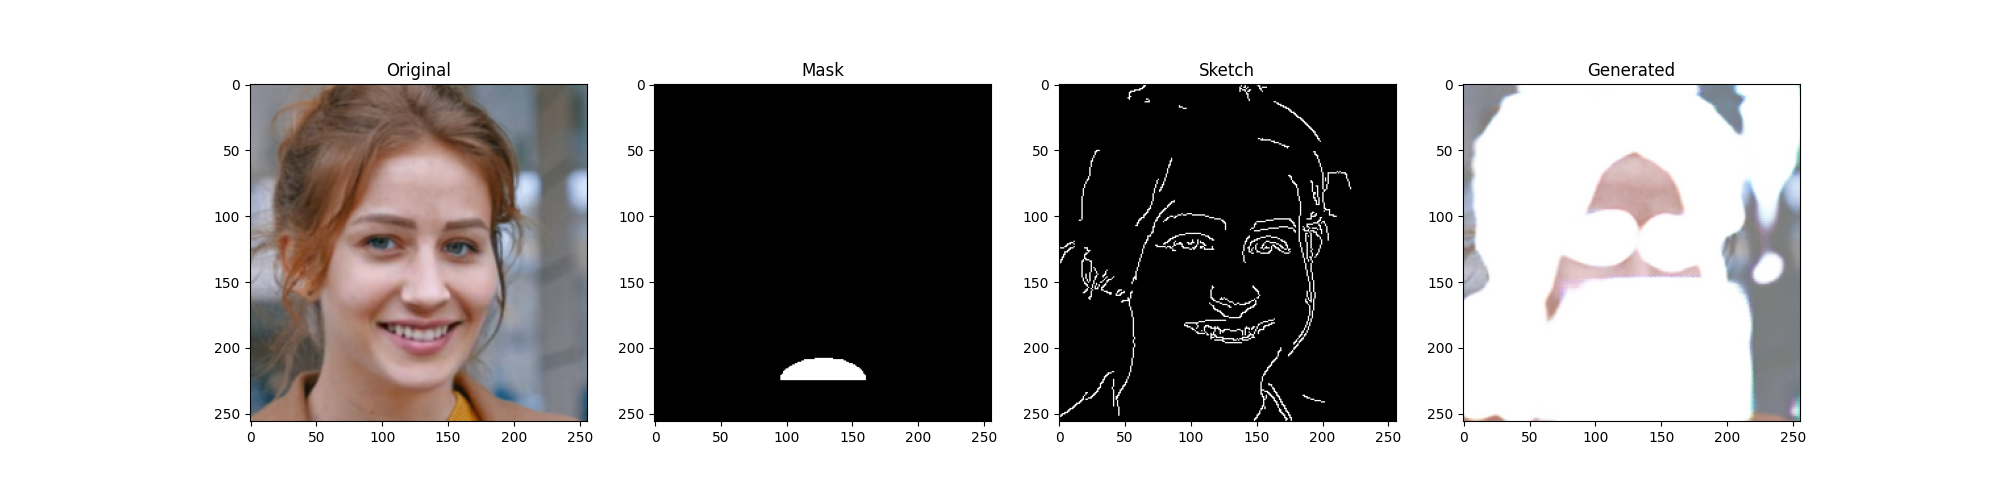

In [72]:
from PIL import Image  # Correct Image import from Pillow
from IPython.display import display  # Only display import from IPython

# Modify paths to match your uploaded files
image_path = f'test_images/{list(uploaded.keys())[0]}'  # use the uploaded image
checkpoint_path = 'checkpoints/best.pt'

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load model
model = load_model(checkpoint_path, device)

# Prepare image
image = prepare_single_image(image_path)
image = image.to(device)

# Create default mask (center region)
mask = torch.zeros_like(image)[:, :1]  # single channel mask
h, w = mask.shape[-2:]
mask[:, :, h//4:3*h//4, w//4:3*w//4] = 1
mask = mask.to(device)

# Create empty sketch
sketch = torch.zeros_like(mask).to(device)

# Generate inpainting
with torch.no_grad():
    output = model(image, mask, sketch)
    output = torch.clamp(output, -1, 1)

# Save and display results
save_results(image, mask, sketch, output)

# Display the result
Image.open(('results/inpainting_result2.png'))
